In [201]:
import sys
from pathlib import Path
import numbers
import random
import json
from itertools import chain
print(sys.executable)
print(sys.version)
sys.path.extend(['..', '../..'])
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from skimage import transform, color
import cv2
import imageio
from quant.experiment.clustering import Clustering
from base.data.wsi_reader import WSIReader

/well/rittscher/users/achatrian/.conda/envs/pyenvclone/bin/python
3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [33]:
manual_data_path = '/well/rittscher/projects/prostate-gland-phenotyping/WSI/data/other/manual_results.compiled.csv'
m = pd.read_csv(manual_data_path, header=[0, 1], true_values=['Y'], false_values=['N'])
m = m.set_index('file_id')
m.index = list(t[0] for t in m.index)  # why is this necessary

In [139]:
m

Case  \
                                                Unnamed: 0_level_1   
EU_7189_16_2D_HandE.ndpi                                   7189/16   
EU_52005_15_2I_HandE+-+2017-11-28+11.23.02.ndpi           52005/15   
EU_49057_14_2F_HandE+-+2017-11-28+10.42.55.ndpi           49057/14   
EU_42628_15_4J_HandE+-+2017-11-28+12.20.38.ndpi           42628/15   
EU_42619_15_2H_HandE+-+2017-11-28+11.31.12.ndpi           42619/15   
EU_38663_17_7G_HandE+-+2017-11-28+11.48.55.ndpi           38663/17   
EU_37747_14_5S_HandE+-+2017-11-28+13.04.58.ndpi           37747/14   
EU_37106_15_2K_HandE+-+2017-11-28+11.43.55.ndpi           37106/15   
EU_36244_16_9A_HandE+-+2017-11-28+12.41.47.ndpi           36244/16   
EU_35928_15_4N_HandE+-+2017-11-28+12.08.09.ndpi           35928/15   
EU_30479_16_G_HandE+-+2017-11-28+12.31.57.ndpi            30479/16   
EU_29797_14_5F_HandE+-+2017-11-28+13.15.48.ndpi           29797/14   
EU_29769_15_1M_HandE+-+2017-11-28+11.56.21.ndpi           29769/15   
EU_29542_16_1S_HandE+-+2017-11-28+12.49.46.ndpi           29542/16   
EU_29373_16_1G_HandE+-+2017-11-28+10.25.19.ndpi           29373/16   
EU_26162_16_9x_HandE+-+2017-11-28+11.03.04.ndpi           26162/16   
EU_2248_16_K_H&E.ndpi                                      2248/16   
EU_18387_14_1E_HandE.ndpi                                 18387/14   
EU_30831_14_4D_HandE+-+2017-11-28+11.15.23.ndpi           30831/14   
17_A047-4463_153D+-+2017-05-11+09.40.22.ndpi               4463/15   
17_A047-4519_1614P+-+2017-05-11+09.50.49.ndpi              4519/16   
17_A047-8544_16J+-+2017-05-11+08.49.27.ndpi                8544/16   
17_A047-10719_16L+-+2017-05-11+08.56.52.ndpi              10719/16   
17_A047-19575_162E+-+2017-05-11+08.34.36.ndpi             19575/16   
17_A047-28956_156N+-+2017-05-11+09.57.53.ndpi             28956/15   
17_A047-29957_152D+-+2017-05-11+10.06.25.ndpi             29957/15   
17_A047-47800_15J+-+2017-05-11+08.12.44.ndpi              47800/15   

                                                % TILs in tumour             \
                                                     Observer 1  Observer 2   
EU_7189_16_2D_HandE.ndpi                                      10          0   
EU_52005_15_2I_HandE+-+2017-11-28+11.23.02.ndpi                0          0   
EU_49057_14_2F_HandE+-+2017-11-28+10.42.55.ndpi               30         10   
EU_42628_15_4J_HandE+-+2017-11-28+12.20.38.ndpi               10          0   
EU_42619_15_2H_HandE+-+2017-11-28+11.31.12.ndpi               10          0   
EU_38663_17_7G_HandE+-+2017-11-28+11.48.55.ndpi               20         20   
EU_37747_14_5S_HandE+-+2017-11-28+13.04.58.ndpi               20         10   
EU_37106_15_2K_HandE+-+2017-11-28+11.43.55.ndpi               10          0   
EU_36244_16_9A_HandE+-+2017-11-28+12.41.47.ndpi               10         10   
EU_35928_15_4N_HandE+-+2017-11-28+12.08.09.ndpi               60         50   
EU_30479_16_G_HandE+-+2017-11-28+12.31.57.ndpi                10          0   
EU_29797_14_5F_HandE+-+2017-11-28+13.15.48.ndpi               10         10   
EU_29769_15_1M_HandE+-+2017-11-28+11.56.21.ndpi               30         10   
EU_29542_16_1S_HandE+-+2017-11-28+12.49.46.ndpi               60          0   
EU_29373_16_1G_HandE+-+2017-11-28+10.25.19.ndpi               40         20   
EU_26162_16_9x_HandE+-+2017-11-28+11.03.04.ndpi                0          0   
EU_2248_16_K_H&E.ndpi                                         30         40   
EU_18387_14_1E_HandE.ndpi                                      0         10   
EU_30831_14_4D_HandE+-+2017-11-28+11.15.23.ndpi               50         20   
17_A047-4463_153D+-+2017-05-11+09.40.22.ndpi                  40         30   
17_A047-4519_1614P+-+2017-05-11+09.50.49.ndpi                  0         20   
17_A047-8544_16J+-+2017-05-11+08.49.27.ndpi                   10          0   
17_A047-10719_16L+-+2017-05-11+08.56.52.ndpi                   0         20   
17_A047-19575_162E+-+2017-05-11+08.34.36.ndpi           

In [31]:
e = Clustering('feat_select_clustering', (), (), caching_path='/well/rittscher/users/achatrian/pipeline_cache')

In [32]:
remove_outliers = False
e.read_data_from_dir('/well/rittscher/projects/prostate-gland-phenotyping/WSI/data/features', max_memory_use=1e10)
if remove_outliers:
    e.remove_outliers()

  5%|▌         | 1/20 [00:07<02:13,  7.05s/it]

Memory usage: 103230105


 10%|█         | 2/20 [00:13<02:03,  6.87s/it]

Memory usage: 167556857


 15%|█▌        | 3/20 [00:18<01:47,  6.31s/it]

Memory usage: 186439757


 20%|██        | 4/20 [00:27<01:52,  7.04s/it]

Memory usage: 336649387


 25%|██▌       | 5/20 [00:33<01:41,  6.73s/it]

Memory usage: 379079200


 30%|███       | 6/20 [00:38<01:29,  6.37s/it]

Memory usage: 397222717


 35%|███▌      | 7/20 [00:44<01:20,  6.19s/it]

Memory usage: 420541954


 40%|████      | 8/20 [00:50<01:12,  6.05s/it]

Memory usage: 433964695


 45%|████▌     | 9/20 [00:55<01:04,  5.88s/it]

Memory usage: 439822955


 50%|█████     | 10/20 [01:01<00:58,  5.90s/it]

Memory usage: 449605643


 55%|█████▌    | 11/20 [01:10<01:00,  6.77s/it]

Memory usage: 563357754


 60%|██████    | 12/20 [01:18<00:56,  7.02s/it]

Memory usage: 632291849


 65%|██████▌   | 13/20 [01:24<00:47,  6.84s/it]

Memory usage: 640652631


 70%|███████   | 14/20 [01:31<00:41,  6.97s/it]

Memory usage: 685868936


 75%|███████▌  | 15/20 [01:40<00:37,  7.42s/it]

Memory usage: 760547417


 80%|████████  | 16/20 [01:47<00:29,  7.49s/it]

Memory usage: 808380014


 85%|████████▌ | 17/20 [01:57<00:24,  8.19s/it]

Memory usage: 921108655


 90%|█████████ | 18/20 [02:06<00:16,  8.22s/it]

Memory usage: 981169722


 95%|█████████▌| 19/20 [02:15<00:08,  8.66s/it]

Memory usage: 1077062791


100%|██████████| 20/20 [02:23<00:00,  8.38s/it]


Memory usage: 1100381981
('17_A047-10719_16L+-+2017-05-11+08.56.52', '17_A047-19575_162E+-+2017-05-11+08.34.36', '17_A047-28956_156N+-+2017-05-11+09.57.53', '17_A047-4463_153D+-+2017-05-11+09.40.22', '17_A047-4519_1614P+-+2017-05-11+09.50.49', '17_A047-47800_15J+-+2017-05-11+08.12.44', '17_A047-8544_16J+-+2017-05-11+08.49.27', 'EU_18387_14_1E_HandE', 'EU_2248_16_K_H&E', 'EU_26162_16_9x_HandE+-+2017-11-28+11.03.04', 'EU_29542_16_1S_HandE+-+2017-11-28+12.49.46', 'EU_29797_14_5F_HandE+-+2017-11-28+13.15.48', 'EU_30479_16_G_HandE+-+2017-11-28+12.31.57', 'EU_30831_14_4D_HandE+-+2017-11-28+11.15.23', 'EU_36244_16_9A_HandE+-+2017-11-28+12.41.47', 'EU_37106_15_2K_HandE+-+2017-11-28+11.43.55', 'EU_38663_17_7G_HandE+-+2017-11-28+11.48.55', 'EU_42628_15_4J_HandE+-+2017-11-28+12.20.38', 'EU_49057_14_2F_HandE+-+2017-11-28+10.42.55', 'EU_52005_15_2I_HandE+-+2017-11-28+11.23.02')
20 feature files were loaded.


In [151]:
label_name = 'Stromal nature grading '
y = m[label_name]['Observer 2']

In [152]:
y

EU_7189_16_2D_HandE.ndpi                           1
EU_52005_15_2I_HandE+-+2017-11-28+11.23.02.ndpi    4
EU_49057_14_2F_HandE+-+2017-11-28+10.42.55.ndpi    4
EU_42628_15_4J_HandE+-+2017-11-28+12.20.38.ndpi    4
EU_42619_15_2H_HandE+-+2017-11-28+11.31.12.ndpi    4
EU_38663_17_7G_HandE+-+2017-11-28+11.48.55.ndpi    3
EU_37747_14_5S_HandE+-+2017-11-28+13.04.58.ndpi    3
EU_37106_15_2K_HandE+-+2017-11-28+11.43.55.ndpi    1
EU_36244_16_9A_HandE+-+2017-11-28+12.41.47.ndpi    1
EU_35928_15_4N_HandE+-+2017-11-28+12.08.09.ndpi    3
EU_30479_16_G_HandE+-+2017-11-28+12.31.57.ndpi     1
EU_29797_14_5F_HandE+-+2017-11-28+13.15.48.ndpi    4
EU_29769_15_1M_HandE+-+2017-11-28+11.56.21.ndpi    2
EU_29542_16_1S_HandE+-+2017-11-28+12.49.46.ndpi    3
EU_29373_16_1G_HandE+-+2017-11-28+10.25.19.ndpi    1
EU_26162_16_9x_HandE+-+2017-11-28+11.03.04.ndpi    4
EU_2248_16_K_H&E.ndpi                              1
EU_18387_14_1E_HandE.ndpi                          1
EU_30831_14_4D_HandE+-+2017-11-28+11.15.23.ndp

In [153]:
classes = True
if classes:
    for v in np.unique(y):
        print(np.sum(y == v))

8
3
7
9


In [154]:
labels = []
for (slide_id, bounding_box), feats in e.x.iterrows():
    labels.append(y[slide_id + '.ndpi'])

In [168]:
x = minmax_scale(e.x)
print(x.min(), x.max())

/well/rittscher/users/achatrian/.conda/envs/pyenvclone/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64.
  """Entry point for launching an IPython kernel.


0.0 1.0000000000000002


In [169]:
ss = StandardScaler()
x = ss.fit_transform(x)
print(min(ss.mean_), max(ss.mean_), min(ss.var_), max(ss.var_), x.min(), x.max())

5.2526871169563556e-05 0.9896762730552693 4.020762545843252e-05 0.24911225738590012 -138.97057421875098 139.0836405448562


In [157]:
pca = PCA(n_components=100)
x = pca.fit_transform(x)

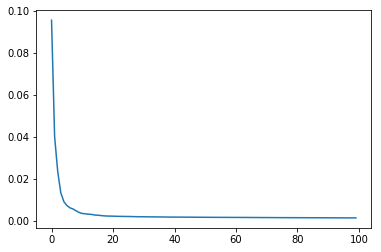

In [158]:
plt.plot(pca.explained_variance_ratio_)

In [171]:
print(x.shape, len(labels))
classes = True
if classes:
    for v in np.unique(labels):
        print(np.sum(labels == v))

(19347, 7100) 19347
3435
2225
6942
6745


In [170]:
x_train, x_test, y_train, y_test = train_test_split(
...     x, labels, test_size=0.30, random_state=42)

In [172]:
xtr = XGBClassifier(n_estimators=100, max_depth=10)
xtr.fit(x_train, y_train)

KeyboardInterrupt: 

In [166]:
xtr.score(x_test, y_test)

0.500947459086994

In [167]:
yhat = xtr.predict(x_test)
print(np.mean(yhat == y_test))

0.500947459086994


In [205]:
## try with chi2 feat select
x_train, x_test, y_train, y_test = train_test_split(e.x, labels, test_size=0.30, random_state=42)
svc = LinearSVC()
p = Pipeline((
    ('mm', MinMaxScaler()),
    ('ss', StandardScaler()),
    ('fs', SelectFromModel(svc)),
    ('clf', XGBClassifier(n_estimators=100))
))

In [206]:
print(x_train.shape, len(y_train))

(13542, 7100) 13542


In [207]:
yhat = p.fit(x_train, y_train)

/well/rittscher/users/achatrian/.conda/envs/pyenvclone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  # Reset internal state before fitting
/well/rittscher/users/achatrian/.conda/envs/pyenvclone/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  # Regarding rnd.randint(..) in the above signature:
